# Vehicle Detection

In [111]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

%matplotlib inline

In [17]:
ROOT_PATH = Path('/home/downloads/carnd-p5-vehicle-detection')

## HOG Features

In [18]:
img_car_path = ROOT_PATH/'images/examples/car.png'
img_notcar_path = ROOT_PATH/'images/examples/notcar.png'

img_car = plt.imread(img_car_path.as_posix())
img_notcar = plt.imread(img_notcar_path.as_posix())

Image shape (64, 64, 3)


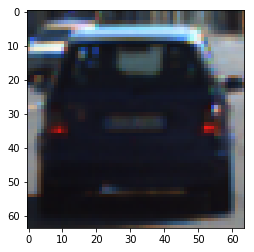

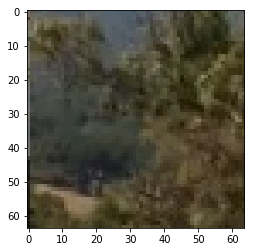

In [19]:
print('Image shape', img_car.shape)
plt.imshow(img_car)
plt.show()
plt.imshow(img_notcar)
plt.show()

In [50]:
def vis_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                    feature_vec=False):
    
    hog_img = None
    if vis:
        hog_features, hog_img = hog(img, orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualize=vis, feature_vector=feature_vec, block_norm='L2-Hys')
    else:
        hog_features = hog(img, orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        visualize=vis, feature_vector=feature_vec, block_norm='L2-Hys')
    return hog_features, hog_img

In [56]:
gray = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
features, hog_img = vis_hog_features(gray, orient=9, 
                                         pix_per_cell= 8, cell_per_block= 2, 
                                         vis=True, feature_vec=False)

In [57]:
print('Shape of features array: ', features.shape)

Shape of features array:  (7, 7, 2, 2, 9)


Text(0.5,1,'HOG Visualization')

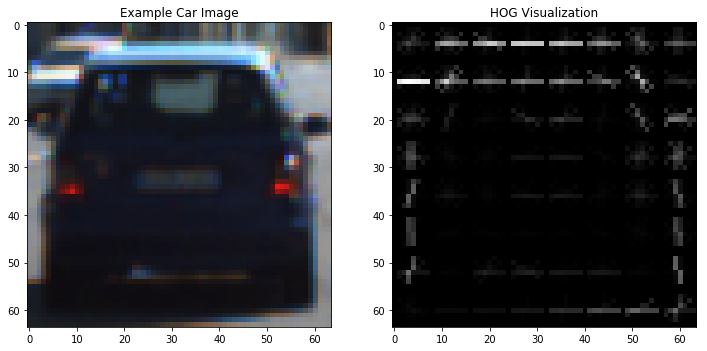

In [58]:
# Plot the examples
fig = plt.figure(figsize=(12, 9))
plt.subplot(121)
plt.imshow(img_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

## HOG Classify

In [82]:
def extract_hog_features_cspace(image, cspace='RGB', orient=9,
                                pix_per_cell=8, cell_per_block=2, hog_channel=0):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
        
    if hog_channel == 'ALL':
        hog_features = []
        for ch in range(feature_image.shape[2]):
            hog_feature_ch, _ = extract_hog_features(image[:, :, ch],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True)
            hog_features.append(hog_feature)
            hog_features = np.ravel(hog_features)
        
    else:
        hog_features, _ = extract_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
    return hog_features

In [83]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

In [86]:
extract_hog_features_cspace(img_car)

array([0.11771985, 0.02919941, 0.03695787, ..., 0.        , 0.01711463,
       0.16758974])

Read images with cars and without cars

In [87]:
CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/KITTI_extracted'
NOTCAR_IMAGES_PATH = ROOT_PATH/'data/non-vehicles/GTI'

print('Total car images: ', len(list(CAR_IMAGES_PATH.iterdir())))
print('Not car iMages: ', len(list(NOTCAR_IMAGES_PATH.iterdir())))

In [119]:
SAMPLE_SIZE = 1000

car_features = []
for file in CAR_IMAGES_PATH.glob('*png'):
    if len(car_features) > SAMPLE_SIZE:
        break
    
    img = plt.imread(file.as_posix())
    hog_features = extract_hog_features_cspace(img)
    car_features.append(hog_features)

notcar_features = []
for file in NOTCAR_IMAGES_PATH.glob('*png'):
    if len(notcar_features) > SAMPLE_SIZE:
        break
        
    img = plt.imread(file.as_posix())
    hog_features = extract_hog_features_cspace(img)
    notcar_features.append(hog_features)

In [120]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('Shape of X: ', X.shape)

Shape of X:  (2002, 1764)


In [121]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Shape of y: ', y.shape)

Shape of y:  (2002,)


Random split

In [122]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [123]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Training

In [124]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9825
My SVC predicts:  [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
For these 10 labels:  [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
0.00088 Seconds to predict 10 labels with SVC


## Sliding windows

In [138]:
def slide_window(img, x_start_stop=[0, None], y_start_stop=[0, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # number of windows in x and y
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list = []
    for xs in range(nx_windows):
        for ys in range(ny_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [139]:
test_image_path = ROOT_PATH/'images/test_images/test1.jpg'
test_image = plt.imread(test_image_path.as_posix())

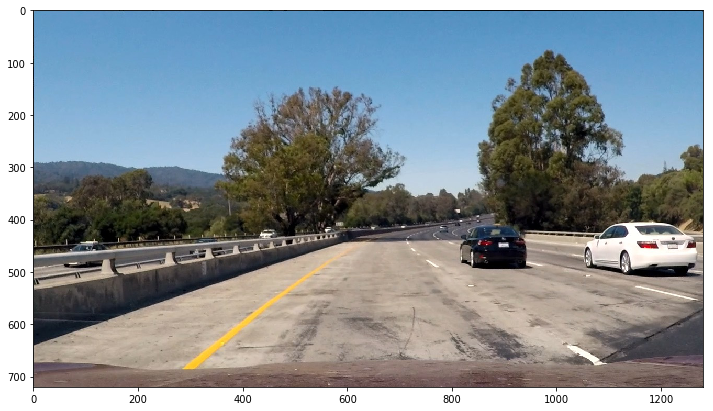

In [140]:
plt.figure(figsize=(12,9))
plt.imshow(test_image)

In [163]:
windows = slide_window(test_image, xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [164]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [167]:
windows[0]

((0, 0), (128, 128))

In [165]:
img = draw_boxes(test_image, windows)

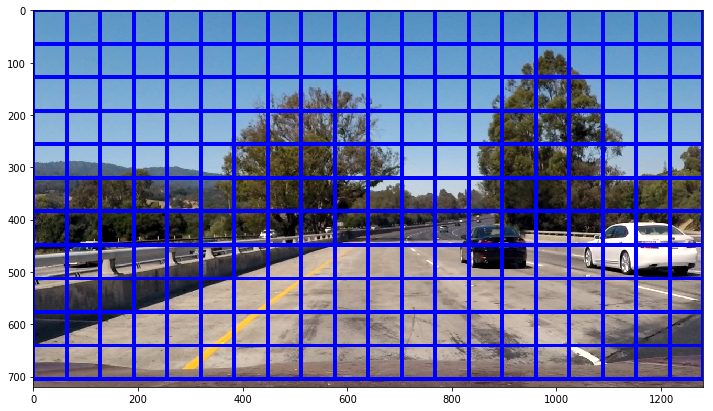

In [178]:
plt.figure(figsize=(12, 10))
plt.imshow(img)